# 1. Import the Images
Import the frog dataset from Jon Shamir with the following [link](https://github.com/jonshamir/frog-dataset). There are 3 types of dataset: 224x224, 64x63, and raw images of the frog. Each of the images has its background removed. There is an error when using further version of tensorflow 2.13. As a result, I will be using tensorflow 2.13.

In [71]:
# Check tensorflow version
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from skimage.feature import canny
print(tf.__version__)

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs found.")

2.13.0
GPUs available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


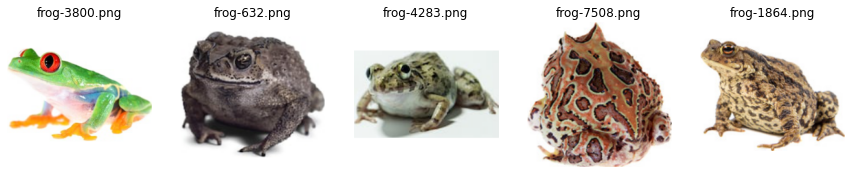

In [26]:
# Set the image path
def show_img(IMG_PATH, N=5):
  # Set the images
  img = [f for f in os.listdir(IMG_PATH) if f.endswith('png')]

  # Select N images
  random_img = random.sample(img, N)

  # Plot the images
  plt.figure(figsize=(15,10))
  for i, img in enumerate(random_img):
    img_path = os.path.join(IMG_PATH, img)
    plt.subplot(1, N, i + 1)
    plt.imshow(mpimg.imread(img_path), cmap='gray')
    plt.axis('off')
    plt.title(img)
  plt.show()

IMG_PATH = 'data/interim/Original/data-224'
show_img(IMG_PATH)

# 2. Creating Sketches

We will use [DexiNed](https://github.com/xavysp/DexiNed/tree/master/DexiNed-TF2), [Canny](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html), and [U2Net](https://github.com/shreyas-bk/U-2-Net) to turn our images into sketches. You can also use the [Google Colab](https://colab.research.google.com/github/shreyas-bk/U-2-Net-Demo/blob/master/DEMOS/U_2_Netp_Demonstration_Colab.ipynb#scrollTo=eWxv7eDJiq5b) for U2Net. Make sure to downloade the [weight](https://drive.google.com/file/d/19Gwa6egqzNolvX4eUoXn-SjRKzxB68AA/view) of the DexiNet.

## DexiNed(Image)

In [6]:
!python DexiNed_TF2/main.py \
--model_state="test" \
--test_dir="data/interim/Original/data-224" \
--output_dir="data/interim/DexiNed-fuse" \
--checkpoint_dir="DexiNed_TF2/checkpoint" \
--checkpoint="DexiNed23_model.h5" \
--test_img_height=224 \
--test_img_width=224 \
--test_bs=32

2024-11-20 13:27:19.225133: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-20 13:27:19.225180: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-20 13:27:19.225187: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-20 13:27:19.225228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 13:27:19.225248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/sketch2frog_gpu/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called mu

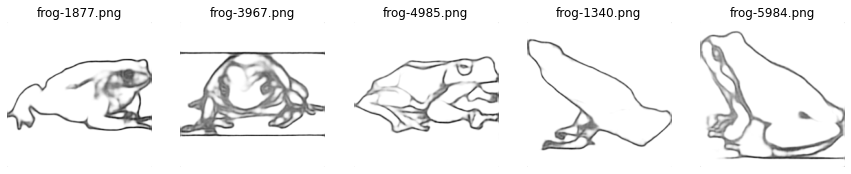

In [27]:
# Check the picture of DexiNed(Img)
# Set the image path
IMG_PATH = 'data/interim/DexiNed-fuse/DexiNed-BIPED2CLASSIC/fuse'
show_img(IMG_PATH)

## Canny(DexiNed(Image))

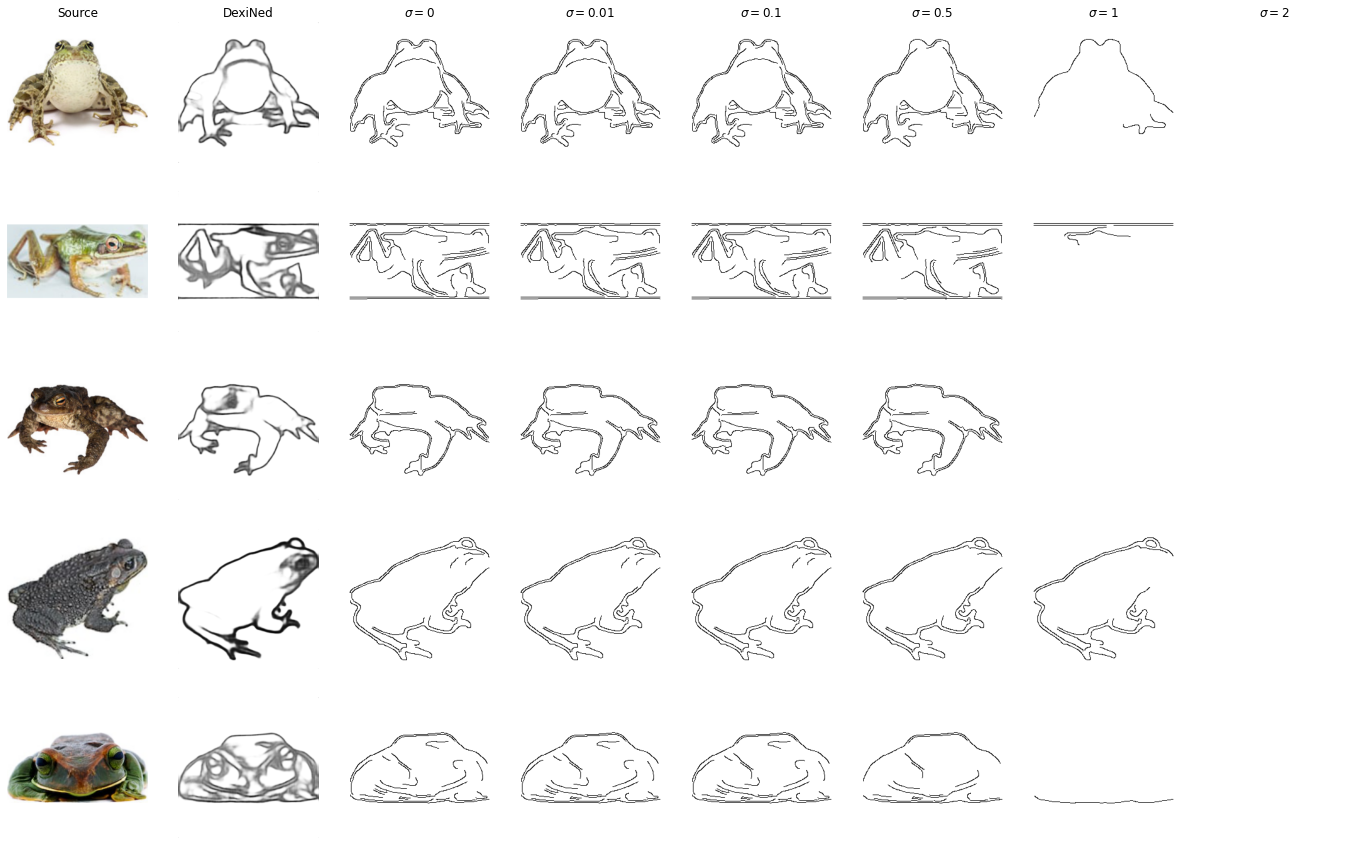

In [ ]:
def print_canny_examples(n=5, sigmas=[1,3], size=2, canny_kw=None):
    # Images
    FUSE_PATH = 'data/interim/DexiNed-fuse/DexiNed-BIPED2CLASSIC/fuse'
    dexi_path = [os.path.relpath(os.path.join(FUSE_PATH, f)) for f in os.listdir(FUSE_PATH) if f.endswith('png')]
    
    # Creating grid
    fig, axs = plt.subplots(n, 2+len(sigmas), figsize=(size*(2+len(sigmas)), size*n))

    # Iterate over the grid
    for i, ax in enumerate(axs):
        
        # Bring the source image and dexi(images)
        sketch_path = random.choice(dexi_path)
        source_path = sketch_path.__str__().replace('DexiNed-fuse/DexiNed-BIPED2CLASSIC/fuse', 'Original/data-224')
        dexi = plt.imread(sketch_path)
        source = plt.imread(source_path)
        ax[0].imshow(source)
        ax[1].imshow(dexi, cmap='gray')

        # Using Canny --> Canny(Dexi(Image))
        edges = [canny(dexi, sigma=sigma, **canny_kw) for sigma in sigmas]

        # Plot the Canny
        for i, x in enumerate(ax[2:]):
            x.imshow(edges[i], cmap='gray_r')
        for a in ax:
            a.axis('off')
    
    # add titles to top row
    axs[0][0].set_title('Source')
    axs[0][1].set_title('DexiNed')
    for i, ax in enumerate(axs[0][2:]):
        ax.set_title(f'$\sigma={sigmas[i]}$')
        
    plt.show()

canny_kw = dict(
    high_threshold=2,
    low_threshold=1,
)   

print_canny_examples(n=5, sigmas=[0, 0.01, 0.1, 0.5, 1, 2], size=3, canny_kw=canny_kw)


## U2Net

Using U2Net to remove background colors: shades and background.

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2

!python -W ignore U-2-Net/u2net_test.py

['data/interim/Original/data-224/frog-1363.png', 'data/interim/Original/data-224/frog-7712.png', 'data/interim/Original/data-224/frog-3574.png', 'data/interim/Original/data-224/frog-869.png', 'data/interim/Original/data-224/frog-5105.png', 'data/interim/Original/data-224/frog-5663.png', 'data/interim/Original/data-224/frog-3212.png', 'data/interim/Original/data-224/frog-7074.png', 'data/interim/Original/data-224/frog-1405.png', 'data/interim/Original/data-224/frog-7060.png', 'data/interim/Original/data-224/frog-1411.png', 'data/interim/Original/data-224/frog-2118.png', 'data/interim/Original/data-224/frog-5677.png', 'data/interim/Original/data-224/frog-4569.png', 'data/interim/Original/data-224/frog-3206.png', 'data/interim/Original/data-224/frog-3560.png', 'data/interim/Original/data-224/frog-5111.png', 'data/interim/Original/data-224/frog-1377.png', 'data/interim/Original/data-224/frog-6418.png', 'data/interim/Original/data-224/frog-7706.png', 'data/interim/Original/data-224/frog-855

## U2Net(Original) and U2Net(DexiNed)


             INPUT                  BACKGROUND REMOVED               BOUNDING BOX                  SALIENT MAP



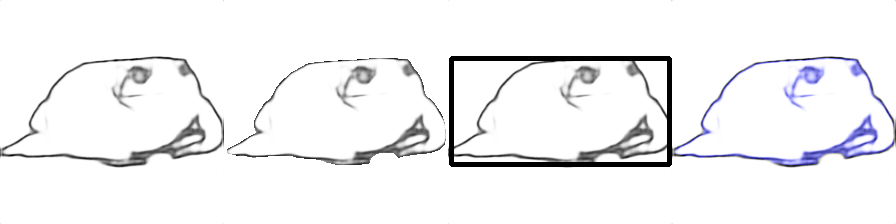


             INPUT                  BACKGROUND REMOVED               BOUNDING BOX                  SALIENT MAP



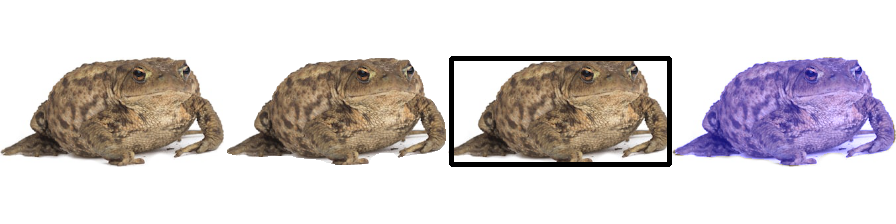

In [98]:
def u2net_image(IMG_PATH, PRED_PATH, name):

  THRESHOLD = 0.9
  RESCALE = 255
  LAYER = 2
  COLOR = (0, 0, 0)
  THICKNESS = 4
  SAL_SHIFT = 100

  # BACKGROUND REMOVAL
  output = load_img(PRED_PATH+name+'.png')
  out_img = img_to_array(output)
  out_img /= RESCALE

  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  shape = out_img.shape
  a_layer_init = np.ones(shape = (shape[0],shape[1],1))
  mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
  a_layer = mul_layer*a_layer_init
  rgba_out = np.append(out_img,a_layer,axis=2)

  input = load_img(IMG_PATH+name+'.png')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

  a_layer = np.ones(shape = (shape[0],shape[1],1))
  rgba_inp = np.append(inp_img,a_layer,axis=2)

  rem_back = (rgba_inp*rgba_out)
  rem_back_scaled = rem_back*RESCALE

  # BOUNDING BOX CREATION

  out_layer = out_img[:,:,LAYER]
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]

  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  start = (startx,starty)
  end = (endx,endy)

  box_img = inp_img.copy()
  box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
  box_img = np.append(box_img,a_layer,axis=2)
  box_img_scaled = box_img*RESCALE

  # SALIENT FEATURE MAP

  sal_img = inp_img.copy()
  add_layer = out_img.copy()
  add_layer[add_layer==1] = SAL_SHIFT/RESCALE
  sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
  sal_img = np.append(sal_img,a_layer,axis=2)
  sal_img_scaled = sal_img*RESCALE
  sal_img_scaled[sal_img_scaled>RESCALE] = RESCALE

  # OUTPUT RESULTS

  inp_img*=RESCALE
  inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
  inp_img = cv2.resize(inp_img,(int(shape[1]),int(shape[0])))
  rem_back = cv2.resize(rem_back_scaled,(int(shape[1]),int(shape[0])))
  box_img = cv2.resize(box_img_scaled,(int(shape[1]),int(shape[0])))
  sal_img = cv2.resize(sal_img_scaled,(int(shape[1]),int(shape[0])))
  result = np.concatenate((inp_img,rem_back,box_img,sal_img),axis=1)
  result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
  print('\n             INPUT                  BACKGROUND REMOVED               BOUNDING BOX                  SALIENT MAP\n')
  display(result_img)

def u2net_result(DEXI_PATH, DEXI_PRED_PATH, N=1):
  ORI_PATH = DEXI_PATH.__str__().replace('DexiNed-fuse/DexiNed-BIPED2CLASSIC/fuse', 'Original/data-224/')
  ORI_PRED_PATH = DEXI_PRED_PATH.__str__().replace('DexiNed-fuse/DexiNed-BIPED2CLASSIC/fuse', 'U2Net(Original)/results/')
  names = [name[:-4] for name in os.listdir(DEXI_PATH)]
  name = random.choice(names)
  u2net_image(DEXI_PATH, DEXI_PRED_PATH, name)
  u2net_image(ORI_PATH, ORI_PRED_PATH, name)

DEXI_PATH = 'data/interim/DexiNed-fuse/DexiNed-BIPED2CLASSIC/fuse/'
DEXI_PRED_PATH = 'data/interim/U2Net(DexiNed)/results/'
u2net_result(DEXI_PATH, DEXI_PRED_PATH)

## DexiNed(U2Net(Original))

In [99]:
!python DexiNed_TF2/main.py \
--model_state="test" \
--test_dir="data/interim/U2Net(Original)/results" \
--output_dir="data/interim/DexiNed(U2Net)/results" \
--checkpoint_dir="DexiNed_TF2/checkpoint" \
--checkpoint="DexiNed23_model.h5" \
--test_img_height=224 \
--test_img_width=224 \
--test_bs=32

2024-11-21 20:34:00.034694: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-21 20:34:00.034734: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-21 20:34:00.034742: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-21 20:34:00.034815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 20:34:00.034860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/sketch2frog_gpu/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called mu

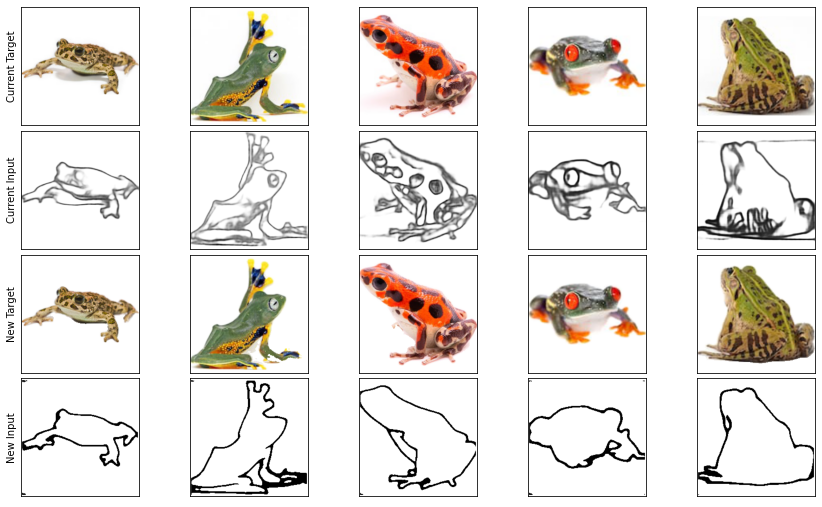

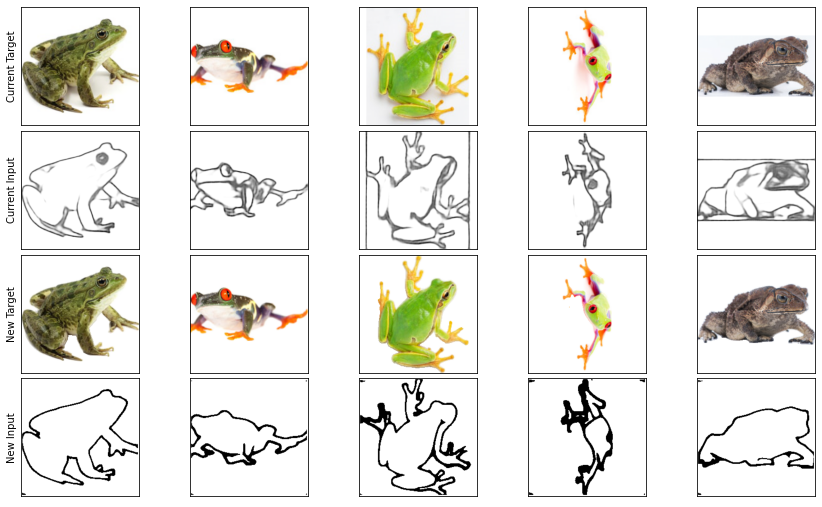

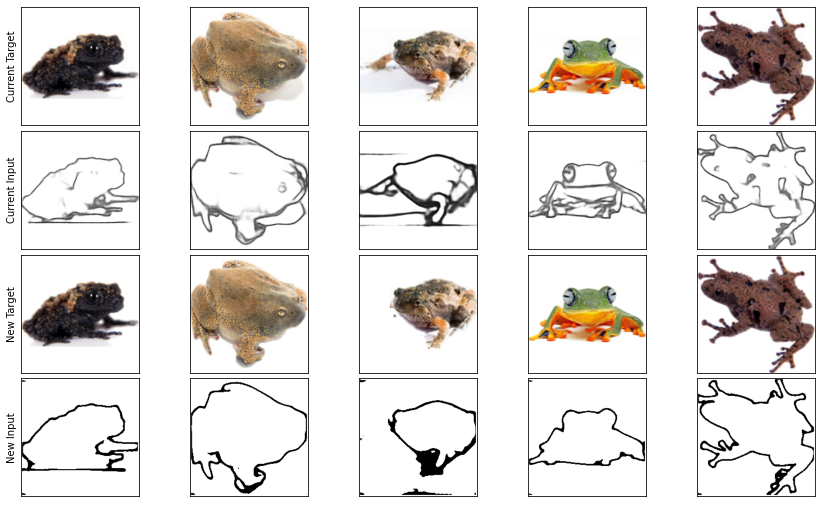

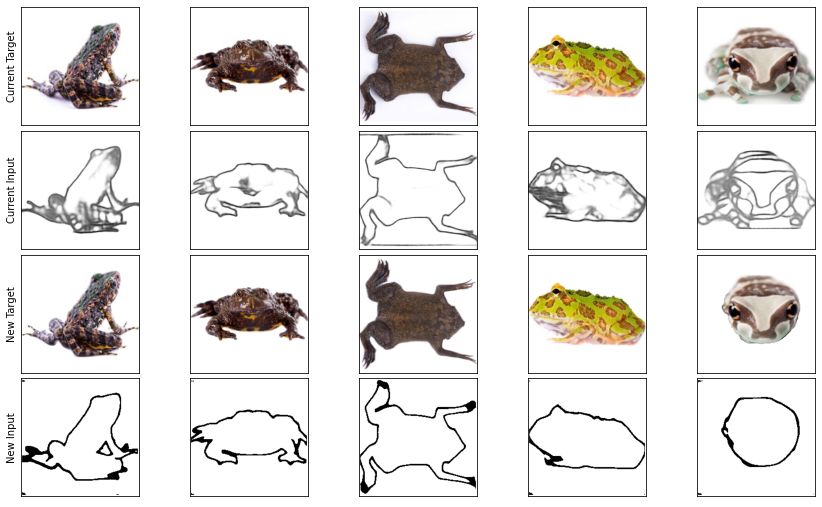

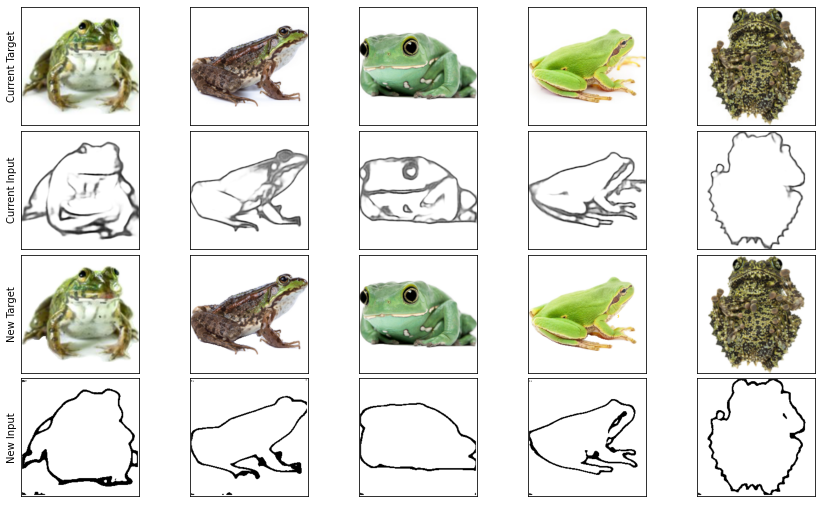

In [102]:
import matplotlib

def plot_final_results(to_plot=5, size=3, target_threshold=0.05, sketch_threshold=0.9, crop=2):
    DEXI_UNET_PATH = 'data/interim/DexiNed(U2Net)/results/DexiNed-BIPED2CLASSIC/fuse'
    CUR_T = 'data/interim/Original/data-224/'
    CUR_S = 'data/interim/DexiNed-fuse/DexiNed-BIPED2CLASSIC/fuse/'
    NEW_T = 'data/interim/U2Net(Original)/results/'
    NEW_S = 'data/interim/DexiNed(U2Net)/results/DexiNed-BIPED2CLASSIC/fuse/'
    names = [name for name in os.listdir(DEXI_UNET_PATH)]
    subset_names = random.sample(names, to_plot)

    fig, axs = plt.subplots(nrows=4, ncols=to_plot, figsize=(size*to_plot, size*3))

    for col, fname in enumerate(subset_names):
        # current target
        source_img = CUR_T + fname
        source_img = plt.imread(source_img)
        axs[0,col].imshow(source_img)
        
        # current sketch
        current_img = CUR_S + fname
        current_img = plt.imread(current_img)
        axs[1,col].imshow(current_img, cmap='gray')
        
        # new target
        unet_fpath = NEW_T + fname
        unet_mask = plt.imread(unet_fpath)[:,:,0]
        unet_mask[unet_mask >  target_threshold] = 1
        unet_mask[unet_mask <= target_threshold] = 0

        # initialise masked image
        unet_masked = source_img.copy()
        # where the mask is zero, set the masked image's rgb values to 0
        unet_masked[:,:,:3] = np.where(unet_mask[:,:,np.newaxis]==0, np.ones_like(unet_masked[:,:,:3]), unet_masked[:,:,:3])
        axs[2,col].imshow(unet_masked)
        
        # new sketch
        sketch_img = NEW_S + fname
        sketch_img = plt.imread(sketch_img)
        
        sketch_img[sketch_img <  sketch_threshold] = 0
        sketch_img[sketch_img >= sketch_threshold] = 1
        # set the edge pixels to white to remove some of the black border errors
        if crop != 0:
            sketch_img = np.pad(sketch_img[crop:-crop, crop:-crop], pad_width=crop,constant_values=1 )
        axs[3,col].imshow(sketch_img, cmap='gray')
        
    for ax in matplotlib.cbook.flatten(axs):
        ax.set(xticks=[], yticks=[])
        
    axs[0,0].set_ylabel('Current Target')
    axs[1,0].set_ylabel('Current Input')
    axs[2,0].set_ylabel('New Target')
    axs[3,0].set_ylabel('New Input')

    fig.patch.set_facecolor('white')      
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()
    
for _ in range(5):
    plot_final_results(
        to_plot=5,
        size=3,
        target_threshold=0.05,
        sketch_threshold=0.9,
        crop=2)

## Further Improvement on the data

We will be using DexiNed(U2Net(Original)). Now we will find the threshold within the DexiNed to better improve our internal information of the sketch.